In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, learning_curve

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Sem V/ML/heart.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N': 0, 'Y': 1})

X = df.drop('HeartDisease', axis=1)
Y = df['HeartDisease']

X_train = X.iloc[:620]
X_test = X.iloc[620:]
y_train = Y.iloc[:620]
y_test = Y.iloc[620:]

In [ ]:
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']
onehot_features = ['Sex', 'ChestPainType', 'RestingECG']
ordinal_features = ['ST_Slope']
st_slope_order = [['Up', 'Flat', 'Down']]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('passthrough', 'passthrough', numeric_features),
        ('onehot', OneHotEncoder(), onehot_features),
        ('ordinal', OrdinalEncoder(categories=st_slope_order), ordinal_features)
    ])

In [ ]:
# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, max_depth=10, min_samples_leaf=4, max_features='sqrt', class_weight='balanced'))
])

# Fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak', 'FastingBS']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Up',
                                                                              'Flat',
                                                                              'Down']]),
                                                  ['ST_Slope'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=4, random_state=42))])

In [ ]:
# 7. Make predictions
y_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

# 8. Evaluate model
print("Training Report:\n", classification_report(y_train, y_train_pred))
print("Testing Report:\n", classification_report(y_test, y_pred))

Training Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       249
           1       0.94      0.99      0.96       371

    accuracy                           0.96       620
   macro avg       0.96      0.95      0.95       620
weighted avg       0.96      0.96      0.96       620

Testing Report:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76       161
           1       0.71      0.77      0.74       137

    accuracy                           0.75       298
   macro avg       0.75      0.75      0.75       298
weighted avg       0.75      0.75      0.75       298



In [ ]:
# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', ]

# Run CV
cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)

# Print mean scores
for metric in scoring:
    print(f"{metric.capitalize()} (mean): {cv_results['test_' + metric].mean():.4f}")

Accuracy (mean): 0.9081
Precision (mean): 0.9020
Recall (mean): 0.9516
F1 (mean): 0.9255


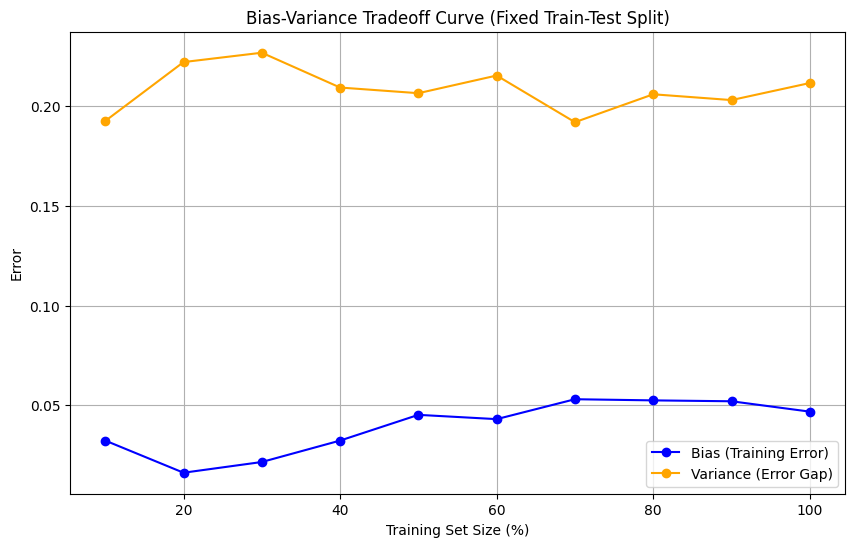

In [ ]:
# Your train/test split sizes
n_train = len(X_train)

# Define fractions of training data to use (10% to 100%)
train_sizes = np.linspace(0.1, 1.0, 10)

train_scores = []
test_scores = []

for frac in train_sizes:
    subset_size = int(frac * n_train)

    # Fix random seed for reproducibility when sampling subsets
    np.random.seed(42)
    indices = np.random.choice(n_train, subset_size, replace=False)

    X_train_subset = X_train.iloc[indices]
    y_train_subset = y_train.iloc[indices]

    # Fit pipeline on the subset
    pipeline.fit(X_train_subset, y_train_subset)

    # Training accuracy on subset
    y_train_pred = pipeline.predict(X_train_subset)
    train_acc = accuracy_score(y_train_subset, y_train_pred)
    train_scores.append(train_acc)

    # Test accuracy on fixed test set
    y_test_pred = pipeline.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_scores.append(test_acc)

# Plotting learning curve
plt.figure(figsize=(10,6))
plt.plot(train_sizes * 100, 1 - np.array(train_scores), marker='o', label='Bias (Training Error)', color='blue')  # Error = 1 - accuracy
plt.plot(train_sizes * 100, np.abs(np.array(train_scores) - np.array(test_scores)), marker='o', label='Variance (Error Gap)', color='orange')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Error')
plt.title('Bias-Variance Tradeoff Curve (Fixed Train-Test Split)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define range of n_estimators to test
n_estimators_range = [10, 50, 100, 150, 200]

# For storing results
train_errors = []
val_errors = []

# Stratified K-Fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n_trees in n_estimators_range:
    train_fold_errors = []
    val_fold_errors = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, Y), 1):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = Y.iloc[train_index], Y.iloc[val_index]

        # Build pipeline with the current n_estimators
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                random_state=42,
                max_depth=10,
                min_samples_leaf=4,
                max_features='sqrt',
                class_weight='balanced',
                n_estimators=n_trees
            ))
        ])

        # Fit model
        pipeline.fit(X_train_fold, y_train_fold)

        # Predict train and val
        y_train_pred = pipeline.predict(X_train_fold)
        y_val_pred = pipeline.predict(X_val_fold)

        # Calculate error (1 - accuracy)
        train_fold_errors.append(1 - accuracy_score(y_train_fold, y_train_pred))
        val_fold_errors.append(1 - accuracy_score(y_val_fold, y_val_pred))

    # Average errors across folds
    train_errors.append(np.mean(train_fold_errors))
    val_errors.append(np.mean(val_fold_errors))

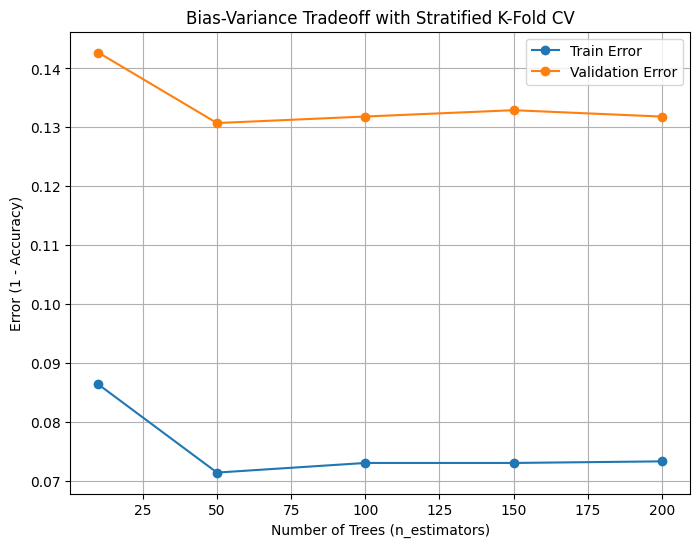

In [ ]:
# Plot bias-variance tradeoff
plt.figure(figsize=(8,6))
plt.plot(n_estimators_range, train_errors, label='Train Error', marker='o')
plt.plot(n_estimators_range, val_errors, label='Validation Error', marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Error (1 - Accuracy)')
plt.title('Bias-Variance Tradeoff with Stratified K-Fold CV')
plt.legend()
plt.grid(True)
plt.show()